# Text generation with an RNN
Recurrent Neural Networks are typically used on __sequences__. Unlike the NNs we have seen so far an RNN takes a __sequence__ of inputs instead of just one. 
The main difference between RRNs and the others is that an RNN contains a __feedback__ loop as shown in the figure below.
The figure also showns an __unrolled__ RNN when the input sequence is of size 4.

![rnn](figures/rnn.png)

### Import TensorFlow and other libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import time
from tensorflow.keras.layers import SimpleRNN,SimpleRNNCell

As we have seen above an RNN layer is basically a sequence of RNN cells that feed each other. To illustrate we compare the output from a SimpleRNN layer in Keras and the output of two SimpleRNN cells that feed one another

In [18]:
## Initial state
init=tf.zeros_like([[0,0,0,0]],dtype='float32')
print(init.shape)
## the input contatins 1 single batch
## of a sequence (size 2) of vectors of dim 4
input=np.array([[1,1,1],[4,4,4]]).astype('float32')
input=input.reshape(1,2,3)
input.shape
## Create a "deterministic" RNN so that we always
## get the same output
rnn=SimpleRNN(4,activation='linear', 
       kernel_initializer=tf.keras.initializers.Constant(1), 
        return_sequences=True,
        recurrent_initializer=tf.keras.initializers.Constant(1)
        )
output=rnn(input,initial_state=init)
print(np.squeeze(output.numpy()))


(1, 4)
[[ 3.  3.  3.  3.]
 [24. 24. 24. 24.]]


### Equivalent network 
Below we build an equivalent network that uses two cells in sequence

In [14]:
seq1=np.array([[1,1,1]]).astype('float32')
seq2=np.array([[3,3,3]]).astype('float32')
### Create a deterministic cell
cell=SimpleRNNCell(4,activation='linear',
        kernel_initializer=tf.keras.initializers.Constant(1),
        recurrent_initializer=tf.keras.initializers.Constant(1)
        )
## output of the first cell
## using seq1 and initialized to init
one=cell(inputs=seq1,states=init)
## output of the second cell
## using seq2 and the output of the previous cell 
two=cell(inputs=seq2,states=one[1])
two=cell(inputs=seq2,states=one[1])
print(one[0])
print(two[0])
print(two[1])

tf.Tensor([[3. 3. 3. 3.]], shape=(1, 4), dtype=float32)
tf.Tensor([[21. 21. 21. 21.]], shape=(1, 4), dtype=float32)
tf.Tensor([[21. 21. 21. 21.]], shape=(1, 4), dtype=float32)


In [85]:
from google.colab import files
file=files.upload()
!mkdir /root/.kaggle
!mv kaggle.json  /root/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


In [3]:
#!kaggle datasets download -d nzalake52/new-york-times-articles
!kaggle datasets download -d ad6398/bbcnewsarticle
!unzip bbcnewsarticle.zip

  0% 0.00/1.83M [00:00<?, ?B/s]
100% 1.83M/1.83M [00:00<00:00, 60.8MB/s]
Archive:  bbcnewsarticle.zip
  inflating: bbc-text.csv            


In [4]:

text=open("bbc-text.csv",encoding='utf8').read()
vocab = sorted(set(text))
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [5]:
# The maximum length sentence you want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
char_dataset

<TensorSliceDataset shapes: (), types: tf.int64>

The `batch` method lets us easily convert these individual characters to sequences of the desired size.

In [6]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
#print(sequences)
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

BATCH_SIZE = 64
BUFFER_SIZE = 10000

#dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

print(dataset)
for d in dataset.take(1):
    print(d[0][0,3].numpy())
    #print(d[0])
    #print(d[1])

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>
36


## Build The Model

Use `tf.keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `tf.keras.layers.GRU`: A type of RNN with size `units=rnn_units` (You can also use an LSTM layer here.)
* `tf.keras.layers.Dense`: The output layer, with `vocab_size` outputs.

In [19]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024
print(vocab_size)

59


In [23]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.SimpleRNN(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (64, None, 256)           15104     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (64, None, 1024)          1311744   
_________________________________________________________________
dense_7 (Dense)              (64, None, 59)            60475     
Total params: 1,387,323
Trainable params: 1,387,323
Non-trainable params: 0
_________________________________________________________________


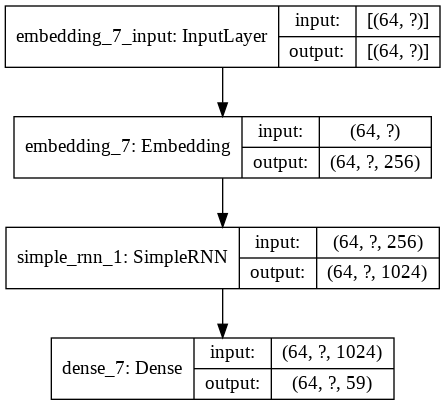

In [24]:
model = build_model(vocab_size=len(vocab),embedding_dim=embedding_dim,rnn_units=rnn_units,batch_size=BATCH_SIZE)
model.summary()
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))    
tf.keras.utils.plot_model(model,show_shapes=True)

In [25]:

EPOCHS = 3
try:
  model.load_weights("weights.h5")
except:
  pass
history = model.fit(dataset, epochs=EPOCHS)
model.save_weights("weights.h5")

Epoch 1/3
782/782 [==============================] - 42s 54ms/step - loss: 2.0453
Epoch 2/3
782/782 [==============================] - 44s 56ms/step - loss: 1.5597
Epoch 3/3
782/782 [==============================] - 44s 56ms/step - loss: 1.4496


## Generate text

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            15104     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_2 (Dense)              (1, None, 59)             60475     
Total params: 5,322,555
Trainable params: 5,322,555
Non-trainable params: 0
_________________________________________________________________


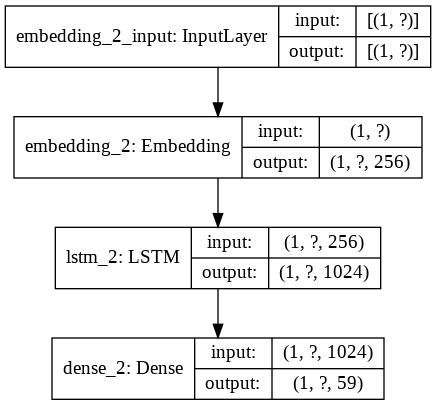

In [14]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights("weights.h5")
#model.build(tf.TensorShape([1, None]))
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True)

### The prediction loop

The following code block generates the text:

* Begin by choosing a start string, initializing the RNN state and setting the number of characters to generate.

* Get the prediction distribution of the next character using the start string and the RNN state.

* Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

* The RNN state returned by the model is fed back into the model so that it now has more context, instead of only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.


![To generate text the model's output is fed back to the input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/text_generation_sampling.png?raw=1)

Looking at the generated text, you'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writing vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

In [12]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = 0.4

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [13]:
print(generate_text(model, start_string=u"telegraph"))

telegraphes . len  the attention automatis and the sites. when they were true for audio from prosudd spending  to close the bosing lina when seeks in uke-student is not information as well enter this. yarnery industry have also up to the get the from social value that a growing global body are raised on the next group of sharen-hip for merrifristry.
sport,new mobile deagh tracking its ways of party s strategist and draw a that had been striker by undermined like that but although smaller spight- boyd is on to go for the authors there s shrongly tries under scotts and just. share all the humers  i.  and offers in effective by code out the top pienceers ago up 35% - desitt the government has been offerged for its extra thousake industrials over the job.  it said anfin stages efforts to have so he bigger bush hest have dramatically extreme games from the potential dosanola  said  and though people are. looked signing a mogie when it is done must donly they can t speed some expects to ut w

The easiest thing you can do to improve the results is to train it for longer (try `EPOCHS = 30`).

You can also experiment with a different start string, try adding another RNN layer to improve the model's accuracy, or adjust the temperature parameter to generate more or less random predictions.